In [2]:
from PIL import Image

# Path to the original image
image_path = r'cropped_sample_512.png'

# Open the image
image = Image.open(image_path)

# Get dimensions of the image
width, height = image.size
width1, height1 = 112,112
# Calculate coordinates for cropping
left = (width - width1) / 2
top = (height - height1) / 2
right = (width + width1) / 2
bottom = (height + height1) / 2

# Crop the image
cropped_image = image.crop((left, top, right, bottom))

# Save the cropped image
cropped_image_path = r'test_image.png'  # Specify path for cropped image
cropped_image.save(cropped_image_path)

print(f"Cropped image saved at: {cropped_image_path}")

Cropped image saved at: test_image.png


In [3]:
from PIL import Image

def enlarge_image(input_path, output_path, new_size=(4094, 2400)):
    # origin
    original_image = Image.open(input_path)
    original_width, original_height = original_image.size

    # new back
    new_image = Image.new("RGB", new_size, (255, 255, 255))

    # central point
    top_left_x = (new_size[0] - original_width) // 2
    top_left_y = (new_size[1] - original_height) // 2

    # in large place
    new_image.paste(original_image, (top_left_x, top_left_y))

    # 保存新图像
    new_image.save(output_path)


input_image_path = 'test_image.png'  

output_image_path = 'enlarged_original_image.png'  
enlarge_image(input_image_path, output_image_path)

In [26]:
import sys
import os
import odak
import numpy as np
import torch


def test(output_directory = 'test_output'):
    odak.tools.check_directory(output_directory)
    resolution = [2400, 4094]
    wavelengths = [639e-9, 515e-9, 473e-9]
    pixel_pitch = 3.74e-6
    number_of_frames = 3
    number_of_depth_layers = 3
    volume_depth = 5e-3
    image_location_offset = 0.
    propagation_type = 'Bandlimited Angular Spectrum'
    propagator_type = 'forward'
    laser_channel_power = None
    aperture = None
    aperture_size = 1800
    method = 'conventional'
    device = torch.device('cpu')
    hologram_phases_filename = 'enlarged_original_image.png'
    hologram_phases = odak.learn.tools.load_image(
                                                  hologram_phases_filename,
                                                  normalizeby = 255.,
                                                  torch_style = True
                                                 ).to(device) * odak.pi * 2
    propagator = odak.learn.wave.propagator(
                                            resolution = resolution,
                                            wavelengths = wavelengths,
                                            pixel_pitch = pixel_pitch,
                                            number_of_frames = number_of_frames,
                                            number_of_depth_layers = number_of_depth_layers,
                                            volume_depth = volume_depth,
                                            image_location_offset = image_location_offset,
                                            propagation_type = propagation_type,
                                            propagator_type = propagator_type,
                                            laser_channel_power = laser_channel_power,
                                            aperture_size = aperture_size,
                                            aperture = aperture,
                                            method = method,
                                            device = device
                                           )
    reconstruction_intensities = propagator.reconstruct(hologram_phases, amplitude = None)
    reconstruction_intensities = torch.sum(reconstruction_intensities, axis = 0)
    for depth_id, reconstruction_intensity in enumerate(reconstruction_intensities):
        odak.learn.tools.save_image(
                                    '{}/reconstruction_image_{:03d}.png'.format(output_directory, depth_id),
                                    reconstruction_intensity,
                                    cmin = 0.,
                                    cmax = 1.
                                   )
    assert True == True

if __name__ == '__main__':
    test()
# if __name__ == '__main__':
#     sys.exit(test())

Cropped image saved at: original_recor_output\cropped_reconstruction_image_000.png


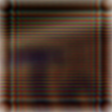

Cropped image saved at: original_recor_output\cropped_reconstruction_image_001.png


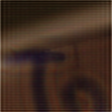

Cropped image saved at: original_recor_output\cropped_reconstruction_image_002.png


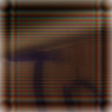

In [27]:
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cropped_folder = 'original_recor_output'
os.makedirs(cropped_folder, exist_ok=True)
# 3 recors in new place
image_paths = [
    'test_output/reconstruction_image_000.png',
    'test_output/reconstruction_image_001.png',
    'test_output/reconstruction_image_002.png'
]


for i, path in enumerate(image_paths):

    image = Image.open(path)
    width, height = image.size
    width1, height1 = 112, 112

    # crop
    left = (width - width1) / 2
    top = (height - height1) / 2
    right = (width + width1) / 2
    bottom = (height + height1) / 2
    cropped_image = image.crop((left, top, right, bottom))

    # save
    cropped_output_path = os.path.join(cropped_folder, f'cropped_reconstruction_image_{i:03d}.png')
    cropped_image.save(cropped_output_path)
    print(f"Cropped image saved at: {cropped_output_path}")

    # display
    display(cropped_image)

In [ ]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchsummary import summary
import piq

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=2000, delta=0.00001, stop_threshold=0.000009):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop_threshold = stop_threshold

    def __call__(self, current_loss):
        if current_loss < self.stop_threshold:
            print(f"Loss reached threshold {self.stop_threshold}, early stopping")
            return True
        if current_loss < self.best_loss - self.delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False
    
def positional_encoding(x, y, num_frequencies=10):
    device = x.device if torch.is_tensor(x) else 'cpu'
    frequencies = 2.0 ** torch.arange(num_frequencies, device=device) * np.pi

    if not torch.is_tensor(x):
        x = torch.tensor(x, device=device)
    if not torch.is_tensor(y):
        y = torch.tensor(y, device=device)

    x_enc = torch.cat([torch.sin(frequencies * x), torch.cos(frequencies * x)])
    y_enc = torch.cat([torch.sin(frequencies * y), torch.cos(frequencies * y)])
    return torch.cat([x_enc, y_enc])


# ====================== MODEL DEFINITIONS ======================
class MLP(nn.Module):
    def __init__(self, input_dim=40, hidden_dims=[32]*4+[16], output_dim=3):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return torch.sigmoid(self.net(x))


class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, is_first=False, omega_0=30.0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)

        with torch.no_grad():
            if self.is_first:
                bound = 1 / in_features
            else:
                bound = np.sqrt(6 / in_features) / omega_0
            self.linear.weight.uniform_(-bound, bound)
            if self.linear.bias is not None:
                self.linear.bias.uniform_(-bound, bound)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class Siren(nn.Module):
    def __init__(self, in_features=2, hidden_features=32, hidden_layers=6, out_features=3):
        super().__init__()
        self.net = nn.ModuleList()

        # first
        self.net.append(SineLayer(in_features, hidden_features, is_first=True))

        # middle
        for _ in range(hidden_layers-2):
            self.net.append(SineLayer(hidden_features, hidden_features))
        self.net.append(SineLayer(hidden_features, 16))

        # last correct to half
        self.final_layer = nn.Sequential(
            nn.Linear(16, out_features),
            nn.Sigmoid()
        )
        with torch.no_grad():
            self.final_layer[0].weight.uniform_(-np.sqrt(6/hidden_features),
                                             np.sqrt(6/hidden_features))

    def forward(self, coords):
        x = coords
        for layer in self.net:
            x = layer(x)
        return self.final_layer(x)

# FiLM-modulated SIREN model
def frequency_init(freq):
    def init(m):
        with torch.no_grad():
            if isinstance(m, nn.Linear):
                num_input = m.weight.size(-1)
                bound = np.sqrt(6 / num_input) / freq
                m.weight.uniform_(-bound, bound)
    return init

class FiLMLayer(nn.Module):
    """Feature-wise Linear Modulation layer"""
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.layer = nn.Linear(input_dim, hidden_dim)

    def forward(self, x, freq, phase_shift):
        return torch.sin(freq * self.layer(x) + phase_shift)

class CustomMappingNetwork(nn.Module):
    def __init__(self, z_dim, map_output_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(z_dim, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, map_output_dim)
        )
        self.network.apply(frequency_init(25))
        with torch.no_grad():
            self.network[-1].weight *= 0.25

    def forward(self, z):
        out = self.network(z)
        return out[..., :out.shape[-1]//2], out[..., out.shape[-1]//2:]

class FilmSIREN(nn.Module):
    """Film-modulated SIREN architecture"""
    def __init__(self, input_dim=2, z_dim=64, hidden_dim=36, out_features=3, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.z = nn.Parameter(torch.randn(1, z_dim))
        self.network = nn.ModuleList([
            FiLMLayer(input_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
        ])
        self.final_layer = nn.Linear(hidden_dim, out_features)
        self.mapping_network = CustomMappingNetwork(z_dim, len(self.network)*hidden_dim*2)
        self.network.apply(frequency_init(25))
        self.final_layer.apply(frequency_init(25))

    def forward(self, coords):
        freqs, phases = self.mapping_network(self.z)
        freqs = freqs * 15 + 30
        x = coords
        for idx, layer in enumerate(self.network):
            start = idx * self.network[0].layer.out_features
            end = (idx+1) * self.network[0].layer.out_features
            x = layer(x, freqs[:, start:end], phases[:, start:end])
        return torch.sigmoid(self.final_layer(x))

# ====================== HELPER FUNCTIONS ======================
def extract_patch_data(patch_img):
    """Extract coordinates and RGB values from image patch"""
    patch_np = np.array(patch_img)
    h, w, _ = patch_np.shape
    y_coords, x_coords = np.indices((h, w))
    coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2)
    rgb_values = patch_np.reshape(-1, 3) / 255.0
    return coords, rgb_values, h, w

def create_weight_mask(patch_size, overlap):
    """Create weight mask for seamless blending"""
    mask = np.ones((patch_size, patch_size, 3), dtype=np.float32)
    for i in range(overlap):
        ratio = i / (overlap - 1)
        mask[:, i] *= ratio
        mask[:, -(i+1)] *= ratio
    for j in range(overlap):
        ratio = j / (overlap - 1)
        mask[j, :] *= ratio
        mask[-(j+1), :] *= ratio
    return mask

# ====================== TRAINING FUNCTIONS ======================
def train_model(model, coords, rgb_values, device, total_steps=10000, steps_til_summary=2000):
    """Train model function"""
    coords_tensor = torch.tensor(coords, dtype=torch.float32).to(device)

    #PS
    if isinstance(model, MLP):
        coords_tensor = torch.stack([
            positional_encoding(c[0], c[1], num_frequencies=10) for c in coords_tensor
        ])

    rgb_tensor = torch.tensor(rgb_values, dtype=torch.float32).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)
    early_stop = EarlyStopping(patience=2000)
    
    for step in range(total_steps):
        optimizer.zero_grad()
        pred = model(coords_tensor)
        loss = criterion(pred, rgb_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if early_stop(loss.item()):
            print(f"Early stopping at step {step}")
            break
        if step % steps_til_summary == 0:
            print(f"Step {step}, Loss: {loss.item():.6f}")
    return model

def generate_patch(model, device, patch_size, actual_size):
    """Generate image patch using trained model"""
    h, w = actual_size
    y_coords, x_coords = np.indices((h, w))
    coords = np.stack((x_coords, y_coords), axis=-1).reshape(-1, 2)
    coords_tensor = torch.tensor(coords, dtype=torch.float32).to(device)
    if isinstance(model, MLP):
        coords_tensor = torch.stack([
            positional_encoding(c[0], c[1], num_frequencies=10) for c in coords_tensor
        ])
    with torch.no_grad():
        rgb_output = model(coords_tensor).cpu().numpy()
    rgb_output = (np.clip(rgb_output, 0, 1) * 255).astype(np.uint8)
    return rgb_output.reshape(h, w, 3)

# ====================== MAIN FUNCTION ======================
def main(model_type='mlp', image_path='test_image.png', patch_size=64, overlap=16, total_steps=15000):
    """Main function for image reconstruction"""
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Selected model: {model_type.upper()}")
    output_folder = f"output_{model_type}"
    os.makedirs(output_folder, exist_ok=True)

    full_img = Image.open(image_path).convert('RGB')
    original_width, original_height = full_img.size
    original_np = np.array(full_img)
    stride = patch_size - overlap
    num_x = (original_width - overlap + stride - 1) // stride
    num_y = (original_height - overlap + stride - 1) // stride
    regenerated_sum = np.zeros((original_height, original_width, 3), dtype=np.float32)
    weight_sum = np.zeros((original_height, original_width, 3), dtype=np.float32)
    weight_mask = create_weight_mask(patch_size, overlap)
    psnr_values = []
    ssim_values = []
    prev_state_dict = None
    patch_count = 0
    
    for i in range(num_x):
        for j in range(num_y):
            left = i * stride
            upper = j * stride
            right = min(left + patch_size, original_width)
            lower = min(upper + patch_size, original_height)
            if i == num_x - 1:
                left = original_width - patch_size
            if j == num_y - 1:
                upper = original_height - patch_size

            patch = full_img.crop((left, upper, right, lower))
            coords, rgb_values, h_patch, w_patch = extract_patch_data(patch)
            actual_size = (h_patch, w_patch)
            
            if model_type == 'mlp':
                model = MLP().to(device)
            elif model_type == 'siren':
                model = Siren().to(device)
            elif model_type == 'filmsiren':
                model = FilmSIREN(device=device).to(device)
            else:
                raise ValueError(f"Unknown model type: {model_type}")
            
            if prev_state_dict is not None:
                if model_type == 'filmsiren':
                    current_state_dict = model.state_dict()
                    for key in prev_state_dict:
                        if key != 'z':
                            current_state_dict[key] = prev_state_dict[key]
                    model.load_state_dict(current_state_dict)
                else:
                    model.load_state_dict(prev_state_dict)
            
            if i == 0 and j == 0:
                if model_type == "mlp":
                    # MLP（positional_encoding）
                    print(f"\n{model_type} model summary:")
                    summary(model, input_size=(40,), device=device.type)
                else:    
                    print(f"\n{model_type} model summary:")
                    summary(model, input_size=(2,), device=device.type)
            
            print(f"\nTraining {model_type} patch ({i},{j}) at [{left}:{right}, {upper}:{lower}]...")
            trained_model = train_model(model, coords, rgb_values, device, total_steps=total_steps)
            
            if model_type == 'filmsiren':
                state_to_save = {k: v for k, v in trained_model.state_dict().items() if k != 'z'}
                prev_state_dict = copy.deepcopy(state_to_save)
            else:
                prev_state_dict = copy.deepcopy(trained_model.state_dict())
            
            model_path = os.path.join(output_folder, f"model_{i}_{j}.pth")
            torch.save(trained_model.state_dict(), model_path)
            patch_array = generate_patch(trained_model, device, patch_size, actual_size)
            original_patch = np.array(patch)
            gen_tensor = torch.from_numpy(patch_array/255.).permute(2,0,1).unsqueeze(0).float()
            org_tensor = torch.from_numpy(original_patch/255.).permute(2,0,1).unsqueeze(0).float()
            psnr = piq.psnr(gen_tensor, org_tensor, data_range=1.0).item()
            ssim = piq.ssim(gen_tensor, org_tensor, data_range=1.0).item()
            psnr_values.append(psnr)
            ssim_values.append(ssim)
            print(f"Patch {patch_count} metrics - PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")
            actual_h, actual_w = lower - upper, right - left
            cropped_mask = weight_mask[:actual_h, :actual_w, :]
            patch_float = patch_array.astype(np.float32)
            regenerated_sum[upper:lower, left:right] += patch_float * cropped_mask
            weight_sum[upper:lower, left:right] += cropped_mask
            patch_count += 1
    
    regenerated = np.zeros_like(regenerated_sum)
    valid_mask = weight_sum > 1e-6
    regenerated[valid_mask] = regenerated_sum[valid_mask] / weight_sum[valid_mask]
    regenerated = np.clip(regenerated, 0, 255).astype(np.uint8)
    output_path = os.path.join(output_folder, f"reconstructed_{model_type}.png")
    Image.fromarray(regenerated).save(output_path)
    print("\n=== FINAL RESULTS ===")
    print(f"Model: {model_type.upper()}")
    print(f"Patches processed: {patch_count}")
    print(f"Local PSNR (avg): {np.mean(psnr_values):.2f} ± {np.std(psnr_values):.2f} dB")
    print(f"Local SSIM (avg): {np.mean(ssim_values):.4f} ± {np.std(ssim_values):.4f}")
    print(f"Reconstructed image saved to: {output_path}")
    return regenerated

if __name__ == "__main__":
    IMAGE_PATH = "test_image.png"
    PATCH_SIZE = 64
    OVERLAP = 16
    TOTAL_STEPS = 5000
    models = ['mlp', 'siren', 'filmsiren']
    results = {}
    
    for model_type in models:
        print(f"\n{'='*50}")
        print(f"RECONSTRUCTING WITH {model_type.upper()} MODEL")
        print(f"{'='*50}")
        result = main(
            model_type=model_type,
            image_path=IMAGE_PATH,
            patch_size=PATCH_SIZE,
            overlap=OVERLAP,
            total_steps=TOTAL_STEPS
        )
        results[model_type] = result
    
    print("\nAll reconstructions completed!")


RECONSTRUCTING WITH MLP MODEL
Using device: cuda
Selected model: MLP

mlp model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,312
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 32]           1,056
              ReLU-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 16]             528
             ReLU-10                   [-1, 16]               0
           Linear-11                    [-1, 3]              51
Total params: 5,059
Trainable params: 5,059
Non-trainable params: 0
---------

In [23]:
from PIL import Image

def enlarge_image(input_path, output_path, new_size=(4094, 2400)):
    original_image = Image.open(input_path)
    original_width, original_height = original_image.size

    # new back
    new_image = Image.new("RGB", new_size, (255, 255, 255))

    # central point
    top_left_x = (new_size[0] - original_width) // 2
    top_left_y = (new_size[1] - original_height) // 2

    # in large place
    new_image.paste(original_image, (top_left_x, top_left_y))

   
    new_image.save(output_path)


input_image_path1 = r'output_filmsiren\reconstructed_filmsiren.png' 
output_image_path1 = r'output_filmsiren\large_filmsiren.png'

input_image_path2 = r'output_siren\reconstructed_siren.png' 
output_image_path2 = r'output_siren\large_siren.png' 

input_image_path3 = r'output_mlp\reconstructed_mlp.png' 
output_image_path3 = r'output_mlp\large_mlp.png'  

enlarge_image(input_image_path1, output_image_path1)
enlarge_image(input_image_path2, output_image_path2)
enlarge_image(input_image_path3, output_image_path3)

Cropped image saved at: output_filmsiren\crop_recor\cropped_reconstruction_image_000.png


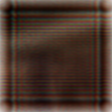

Cropped image saved at: output_filmsiren\crop_recor\cropped_reconstruction_image_001.png


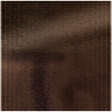

Cropped image saved at: output_filmsiren\crop_recor\cropped_reconstruction_image_002.png


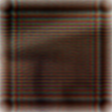

Cropped image saved at: output_siren\crop_recor\cropped_reconstruction_image_000.png


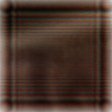

Cropped image saved at: output_siren\crop_recor\cropped_reconstruction_image_001.png


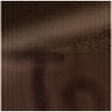

Cropped image saved at: output_siren\crop_recor\cropped_reconstruction_image_002.png


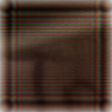

Cropped image saved at: output_mlp\crop_recor\cropped_reconstruction_image_000.png


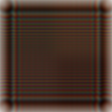

Cropped image saved at: output_mlp\crop_recor\cropped_reconstruction_image_001.png


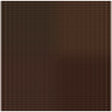

Cropped image saved at: output_mlp\crop_recor\cropped_reconstruction_image_002.png


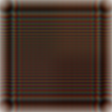

In [25]:
import sys
import os
import odak
import numpy as np
import torch
from PIL import Image
from IPython.display import display

def test(output_directory = 'test_newoutput',hologram_phases_filename = 'add_test\output_filmsiren\large_filmsiren.png'):
    odak.tools.check_directory(output_directory)
    resolution = [2400, 4094]
    wavelengths = [639e-9, 515e-9, 473e-9]
    pixel_pitch = 3.74e-6
    number_of_frames = 3
    number_of_depth_layers = 3
    volume_depth = 5e-3
    image_location_offset = 0.
    propagation_type = 'Bandlimited Angular Spectrum'
    propagator_type = 'forward'
    laser_channel_power = None
    aperture = None
    aperture_size = 1800
    method = 'conventional'
    device = torch.device('cpu')
    hologram_phases_filename = hologram_phases_filename
    hologram_phases = odak.learn.tools.load_image(
                                                  hologram_phases_filename,
                                                  normalizeby = 255.,
                                                  torch_style = True
                                                 ).to(device) * odak.pi * 2
    propagator = odak.learn.wave.propagator(
                                            resolution = resolution,
                                            wavelengths = wavelengths,
                                            pixel_pitch = pixel_pitch,
                                            number_of_frames = number_of_frames,
                                            number_of_depth_layers = number_of_depth_layers,
                                            volume_depth = volume_depth,
                                            image_location_offset = image_location_offset,
                                            propagation_type = propagation_type,
                                            propagator_type = propagator_type,
                                            laser_channel_power = laser_channel_power,
                                            aperture_size = aperture_size,
                                            aperture = aperture,
                                            method = method,
                                            device = device
                                           )
    reconstruction_intensities = propagator.reconstruct(hologram_phases, amplitude = None)
    reconstruction_intensities = torch.sum(reconstruction_intensities, axis = 0)
    for depth_id, reconstruction_intensity in enumerate(reconstruction_intensities):
        odak.learn.tools.save_image(
                                    '{}/reconstruction_image_{:03d}.png'.format(output_directory, depth_id),
                                    reconstruction_intensity,
                                    cmin = 0.,
                                    cmax = 1.
                                   )
    assert True == True


def cropp(cropped_folder):
    
    os.makedirs(cropped_folder, exist_ok=True)

    image_paths = [
        'test_newoutput/reconstruction_image_000.png',
        'test_newoutput/reconstruction_image_001.png',
        'test_newoutput/reconstruction_image_002.png'
    ]


    for i, path in enumerate(image_paths):

        image = Image.open(path)
        width, height = image.size
        width1, height1 = 112, 112

        # crop
        left = (width - width1) / 2
        top = (height - height1) / 2
        right = (width + width1) / 2
        bottom = (height + height1) / 2
        cropped_image = image.crop((left, top, right, bottom))

        # save
        cropped_output_path = os.path.join(cropped_folder, f'cropped_reconstruction_image_{i:03d}.png')
        cropped_image.save(cropped_output_path)
        print(f"Cropped image saved at: {cropped_output_path}")

        # display
        display(cropped_image)

if __name__ == '__main__':
    test(output_directory = 'test_newoutput',hologram_phases_filename = r'output_filmsiren\large_filmsiren.png')
    cropp(r'output_filmsiren\crop_recor')
    test(output_directory = 'test_newoutput',hologram_phases_filename = r'output_siren\large_siren.png')
    cropp(r'output_siren\crop_recor')
    test(output_directory = 'test_newoutput',hologram_phases_filename = r'output_mlp\large_mlp.png')
    cropp(r'output_mlp\crop_recor')
# if __name__ == '__main__':
#     sys.exit(test())

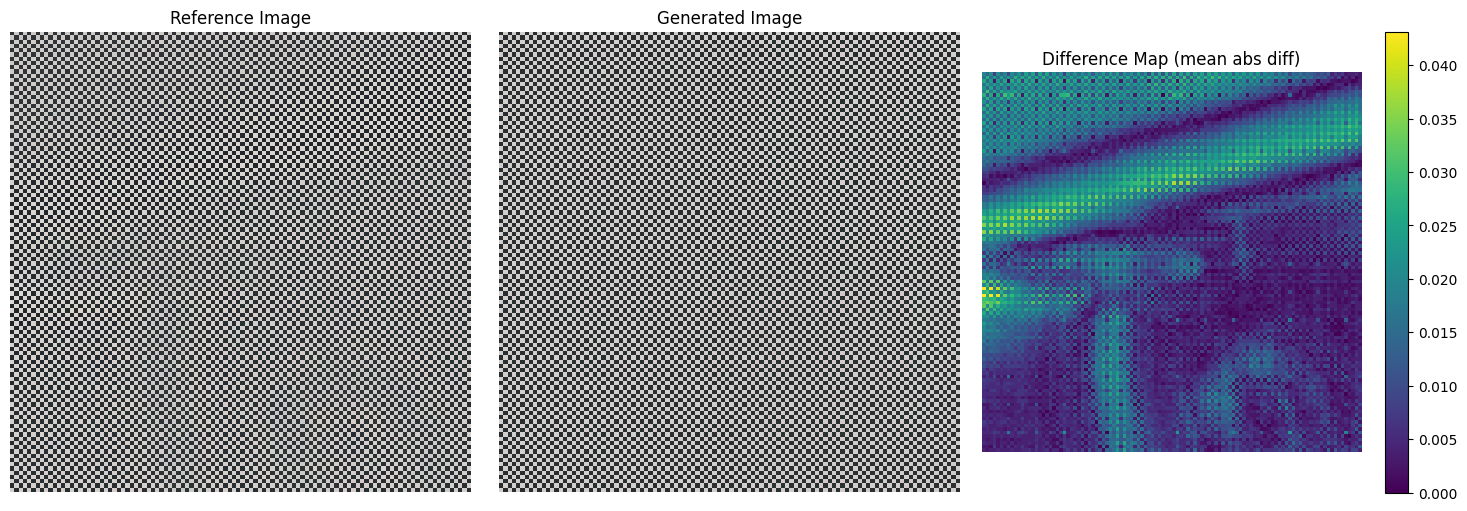

MLP
PSNR: 37.3986 dB
SSIM: 0.9992


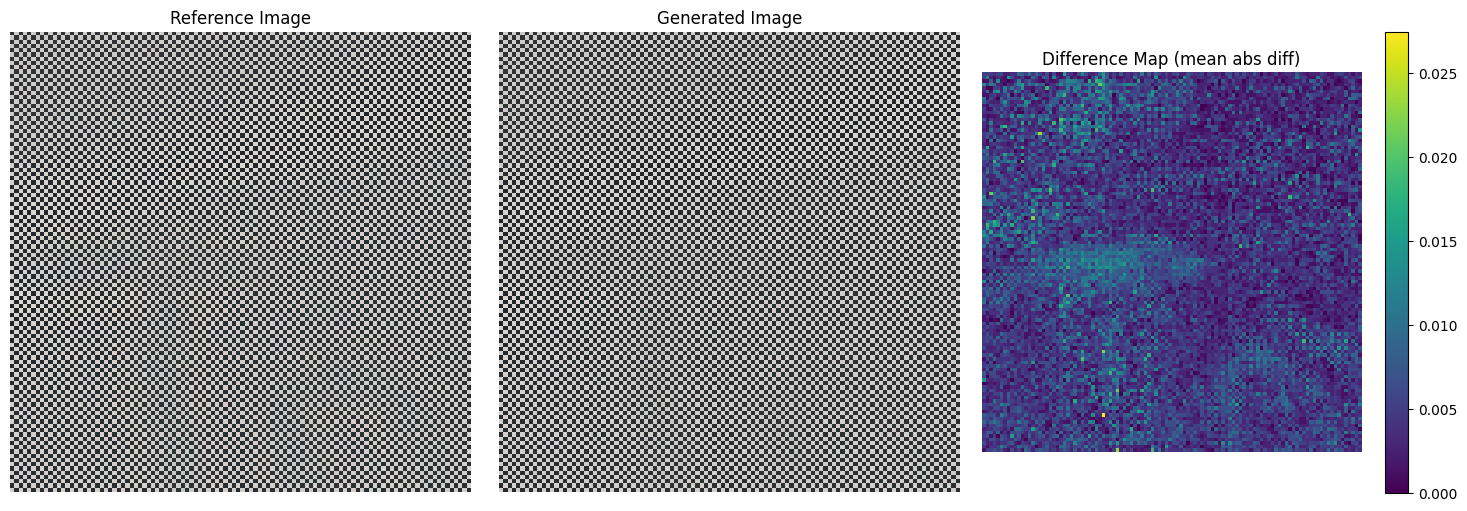

FilmSIREN
PSNR: 43.5875 dB
SSIM: 0.9998


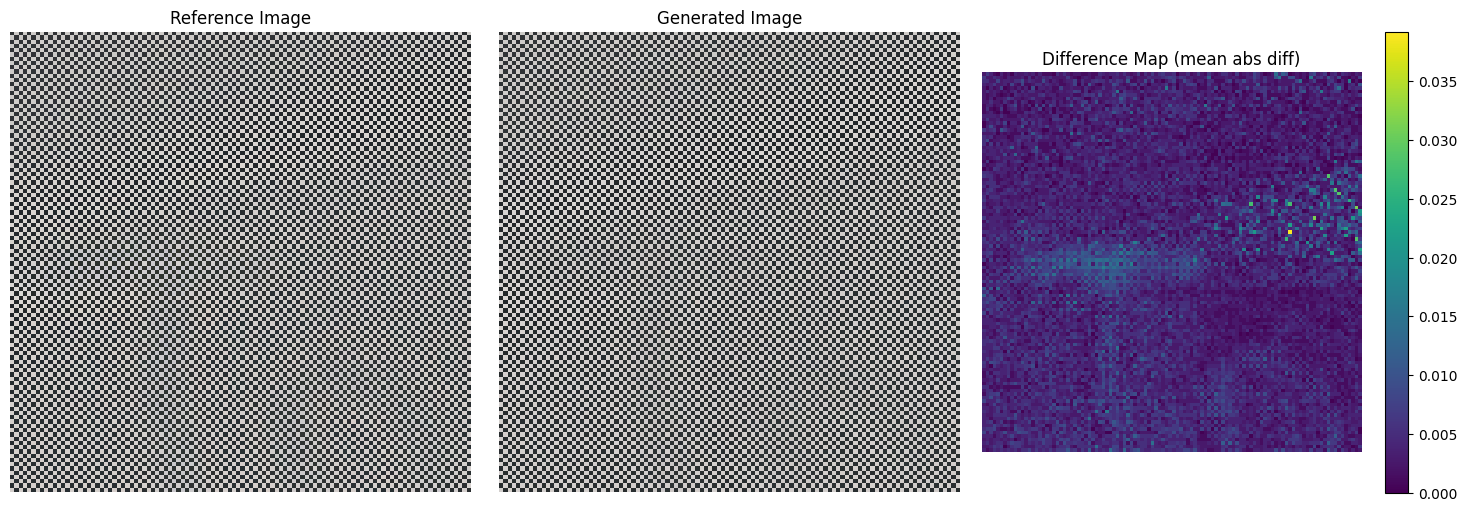

SIREN
PSNR: 44.7057 dB
SSIM: 0.9999


In [20]:
import torch
from PIL import Image
import piq
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def calculate_psnr_ssim(
    ref_path, gen_path, 
    device='cuda' if torch.cuda.is_available() else 'cpu',
    border_crop=0  
):
    ref_img = Image.open(ref_path).convert('RGB')
    gen_img = Image.open(gen_path).convert('RGB')

    # numpy
    ref_np = np.array(ref_img).astype(np.float32) / 255.0
    gen_np = np.array(gen_img).astype(np.float32) / 255.0


    # cut edge
    if border_crop > 0:
        ref_np = ref_np[border_crop:-border_crop, border_crop:-border_crop, :]
        gen_np = gen_np[border_crop:-border_crop, border_crop:-border_crop, :]

    # Tensor
    ref_tensor = torch.tensor(ref_np).permute(2, 0, 1).unsqueeze(0).to(device)
    gen_tensor = torch.tensor(gen_np).permute(2, 0, 1).unsqueeze(0).to(device)

    # metrics
    psnr_val = piq.psnr(gen_tensor, ref_tensor, data_range=1.0).item()
    ssim_val = piq.ssim(gen_tensor, ref_tensor, data_range=1.0).item()

    # diff
    diff_map = np.mean(np.abs(ref_np - gen_np), axis=2)


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Reference Image')
    plt.imshow(ref_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(gen_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Difference Map (mean abs diff)')
    plt.imshow(diff_map, cmap='viridis')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {'PSNR': psnr_val, 'SSIM': ssim_val}


if __name__ == "__main__":
    ref_img = 'test_image.png'
    
    gen_img1 = r'output_mlp\reconstructed_mlp.png'
    gen_img2 = r'output_filmsiren\reconstructed_filmsiren.png'
    gen_img3 = r'output_siren\reconstructed_siren.png'
    results = calculate_psnr_ssim(ref_img, gen_img1, border_crop=2)
    print("MLP")
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")
    
    results = calculate_psnr_ssim(ref_img, gen_img2, border_crop=2)
    print("FilmSIREN")
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")

    results = calculate_psnr_ssim(ref_img, gen_img3, border_crop=2)
    print("SIREN")
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")


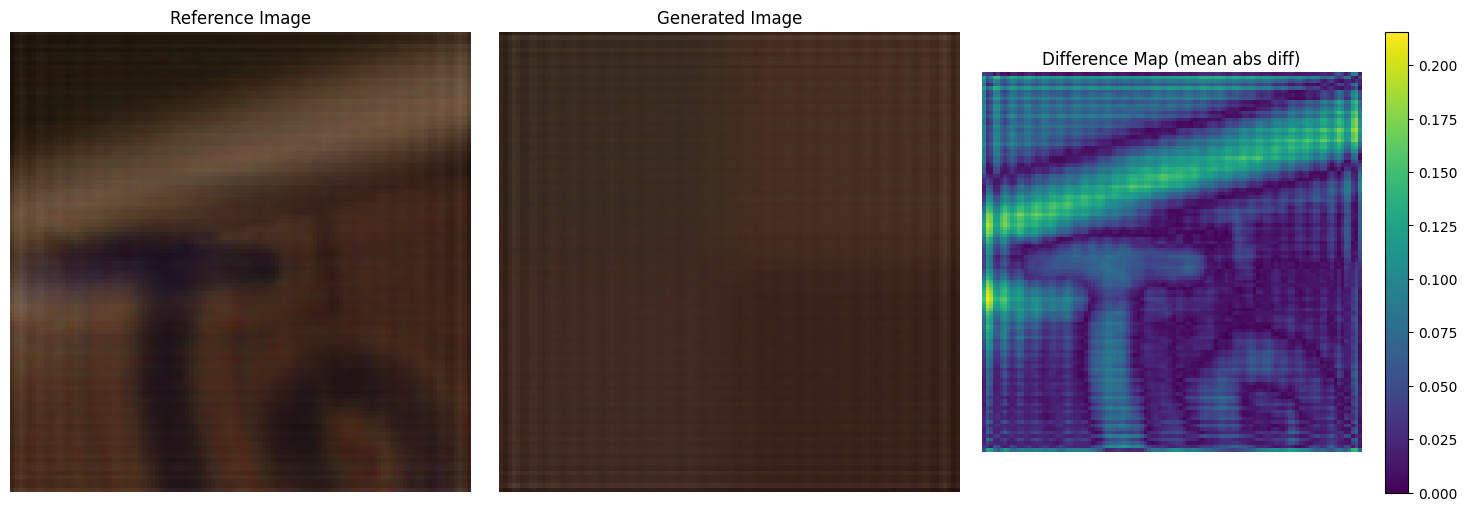

MLP
PSNR: 23.8347 dB
SSIM: 0.7228


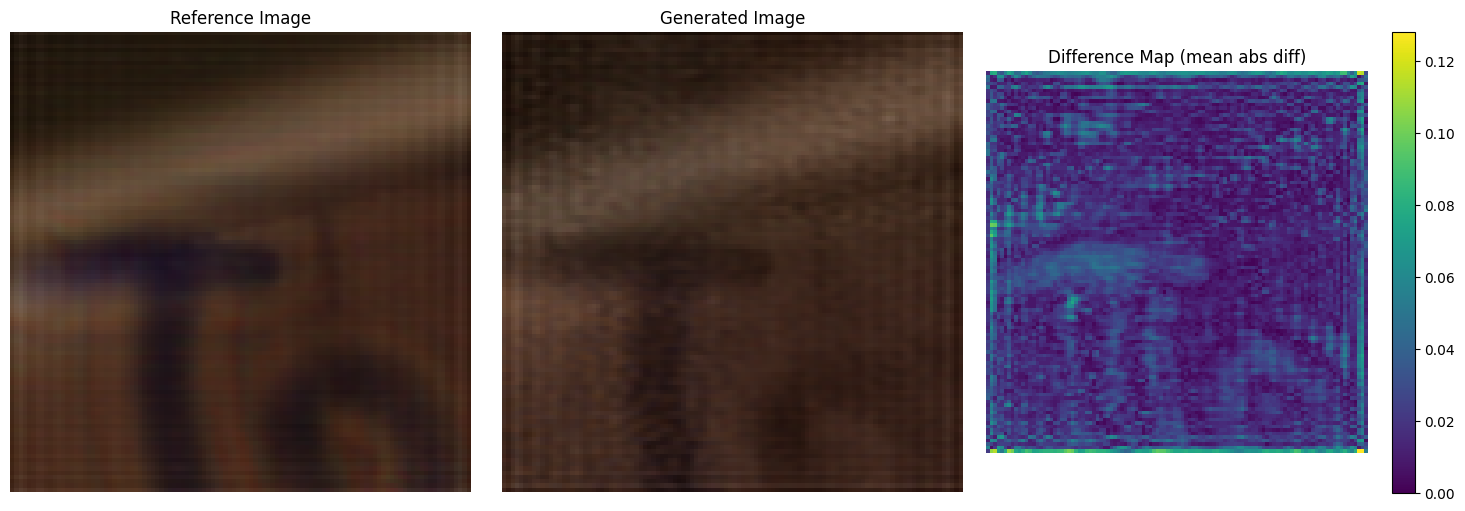

FilmSIREN
PSNR: 31.5635 dB
SSIM: 0.8341


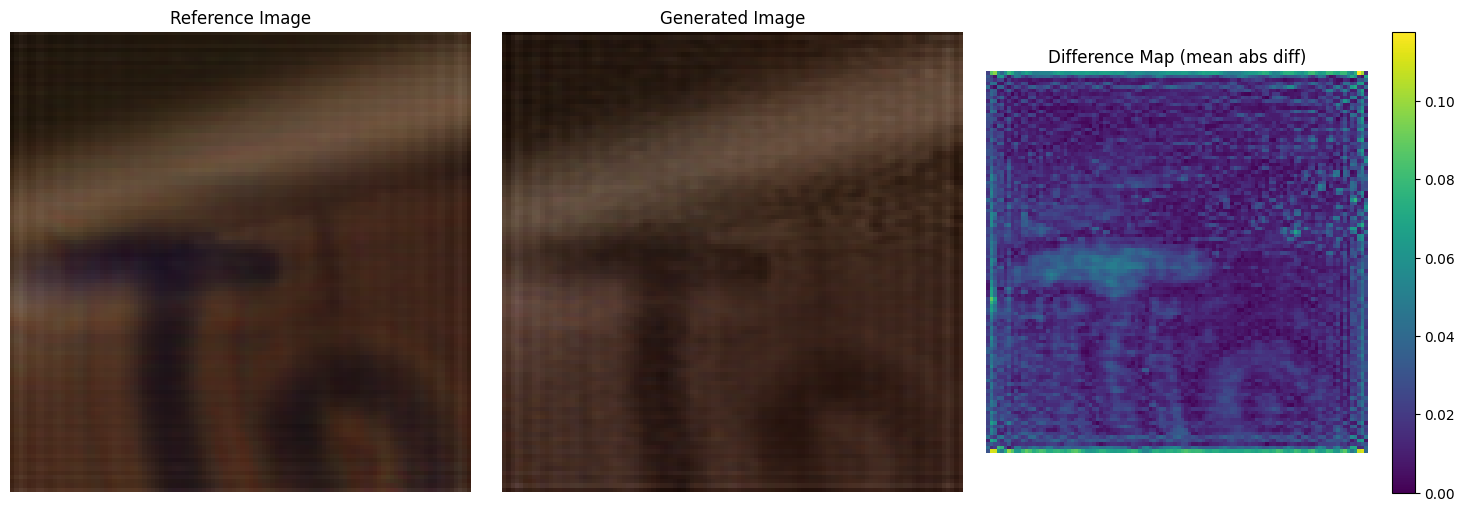

SIREN
PSNR: 32.4128 dB
SSIM: 0.8609


In [31]:
import torch
from PIL import Image
import piq
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def calculate_psnr_ssim(
    ref_path, gen_path, 
    device='cuda' if torch.cuda.is_available() else 'cpu',
    border_crop=0  
):
    ref_img = Image.open(ref_path).convert('RGB')
    gen_img = Image.open(gen_path).convert('RGB')

    # numpy
    ref_np = np.array(ref_img).astype(np.float32) / 255.0
    gen_np = np.array(gen_img).astype(np.float32) / 255.0


    # cut edge
    if border_crop > 0:
        ref_np = ref_np[border_crop:-border_crop, border_crop:-border_crop, :]
        gen_np = gen_np[border_crop:-border_crop, border_crop:-border_crop, :]

    # Tensor
    ref_tensor = torch.tensor(ref_np).permute(2, 0, 1).unsqueeze(0).to(device)
    gen_tensor = torch.tensor(gen_np).permute(2, 0, 1).unsqueeze(0).to(device)

    # metrics
    psnr_val = piq.psnr(gen_tensor, ref_tensor, data_range=1.0).item()
    ssim_val = piq.ssim(gen_tensor, ref_tensor, data_range=1.0).item()

    # diff
    diff_map = np.mean(np.abs(ref_np - gen_np), axis=2)


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Reference Image')
    plt.imshow(ref_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Generated Image')
    plt.imshow(gen_np)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f'Difference Map (mean abs diff)')
    plt.imshow(diff_map, cmap='viridis')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return {'PSNR': psnr_val, 'SSIM': ssim_val}


if __name__ == "__main__":
    ref_img = r'original_recor_output\cropped_reconstruction_image_001.png'

    gen_img1 = r'output_mlp\crop_recor\cropped_reconstruction_image_001.png'
    gen_img2 = r'output_filmsiren\crop_recor\cropped_reconstruction_image_001.png'
    gen_img3 = r'output_siren\crop_recor\cropped_reconstruction_image_001.png'
    results = calculate_psnr_ssim(ref_img, gen_img1, border_crop=2)
    print("MLP")
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")
    
    results = calculate_psnr_ssim(ref_img, gen_img2, border_crop=2)
    print("FilmSIREN")
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")

    results = calculate_psnr_ssim(ref_img, gen_img3, border_crop=2)
    print("SIREN")
    print(f"PSNR: {results['PSNR']:.4f} dB")
    print(f"SSIM: {results['SSIM']:.4f}")
